**Integrantes**
- Erika Espinosa
- Monica Quiroga
- Karla Rodriguez

# Acceder a un entorno de trabajo con GPU

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Instalación de librerias

In [ ]:
!pip install transformers
!pip install emoji
!pip install torch
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.2 MB/s eta 0:00:00
--2023-09-24 00:43:26--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-09-24 00:43:28 ERROR 403: Forbidden.

--2023-09-24 00:43:28--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443

In [ ]:
from transformers import BertModel, BertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
#import torch.nn.functional as F
import pandas as pd
from textwrap import wrap #Fraccionar los parrafos
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
from time import time
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from pickle import dump, load

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Lectura del archivo consolidado

 70506 registros
* Negativo = 0
* Neutro = 1
* Positivo = 2

In [ ]:
df = pd.read_excel('https://raw.githubusercontent.com/moniiandrea/ProyectoMAD/main/DataMAD.xlsx')
df

In [ ]:
df.shape

(70506, 5)

Neutro      36404
Positivo    19718
Negativo    14384
Name: sentiment, dtype: int64


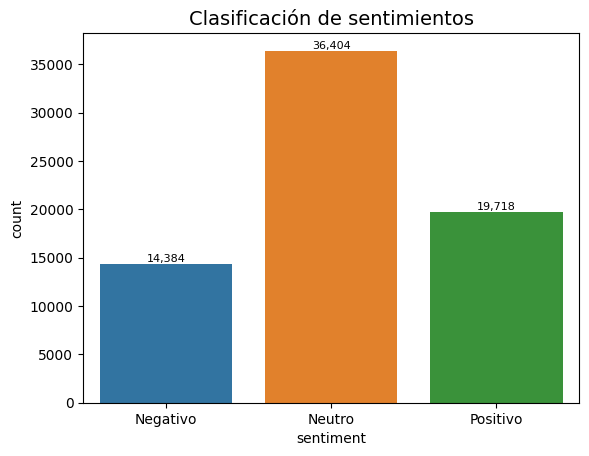

In [ ]:
"""Categorización"""
ncount = df['sentiment'].value_counts()
print(ncount)

sp = df.groupby('sentiment').count().sort_values(by='sentiment',ascending=True)
lst = list(sp.index)
#plt.figure(figsize=(12,5))
plt.title('Clasificación de sentimientos', size = 14.0)
ax = sns.countplot(data=df, x='sentiment',order=lst)
#Etiquetas para las barras
for bar in ax.patches:
  # Obtenemos la altura para las anotaciones.
        bar_value = bar.get_height()
  # Formato de números con separador de miles.
        text = f'{bar_value:,.0f}'
  # Centrar etiquetas de x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
  # get_y() lugar donde empieza la barra y añadimos la altura.
        text_y = bar.get_y() + bar_value
  # Ubicación de las etiquetas de datos de las barras y color
        ax.text(text_x, text_y, text, ha='center',va='bottom', color="black",
          size=8)
#Mostrar gráfico
plt.show()

In [ ]:
#Sample para revisar el funcionamiento
df = df.sample(5000)

# Division de la data y modelo

In [ ]:
'''División de la data'''
from sklearn.model_selection import train_test_split
train_x, val_x, train_labels, val_labels = train_test_split(df['clean_text'], df['sentiment'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['No_sentiment'])

In [ ]:
model_name = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)
config = BertConfig.from_pretrained(model_name)
print (config)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}



## Construccion estructura

In [ ]:
# Inicialización
RANDOM_SEED = 50
MAX_LEN = 128
BATCH_SIZE = 32 #revisar
NCLASSES = 3

In [ ]:
# CREACIÓN DATASET

class Dataset(Dataset):

  def __init__(self,full_text,labels,tokenizer,max_len):
    self.full_text = full_text
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.full_text)

  def __getitem__(self, item):
    full_text = str(self.full_text[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(#representación numerica de los tokens
        full_text,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding='max_length',
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'full_text': full_text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }

In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = Dataset(
      full_text = df.full_text.to_numpy(),
      labels = df.No_sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 2)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

# we will use temp_text and temp_labels to create validation and test set
df_test, df_test2 = train_test_split(df_test, random_state=RANDOM_SEED, test_size=0.5)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader2 = data_loader(df_test2, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
print('Datos de Entrenamiento: ', df_train.shape)
print('Datos de Validación: ', df_test.shape)
print('Datos de Prueba: ', df_test2.shape)
train_data_loader

Datos de Entrenamiento:  (56404, 5)
Datos de Validación:  (7051, 5)
Datos de Prueba:  (7051, 5)


## Modelo

### Modelo Base

* BATCH_SIZE = 32
* EPOCHS = 3
* Lr = 2e-5

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #revisar si mantienen o se quita y hidden_size
    self.gelu = nn.GELU() #funcion utilizada en bert en las capas internas, GELU combina y mejora los resultados por ser una distribución acumulativa, usada en NLP
    self.softmax = nn.Softmax(dim=1) # salida de probabilidades cuando se tienen mas de dos categorias

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
        return_dict=False
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    output = self.gelu(output)
    return self.softmax(output)

In [ ]:
model = BERTSentimentClassifier(NCLASSES).to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

#### Entrenamiento

In [ ]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer,device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
# ENTRENAMIENTO
EPOCHS = 3 #revisar
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Entrenamiento!!!
%%time
history = defaultdict(list)
tiempo_inicial = time()


for epoch in range(EPOCHS):
    print('Epoch {} de {}'.format(epoch+1, EPOCHS))
    print('------------------')
    train_acc, train_loss = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, n_examples=len(df_train))
    test_acc, test_loss = eval_model(
        model, test_data_loader, loss_fn, device, n_examples=len(df_test))
    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
    print('')
    tiempo_final = time()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_acc)

tiempo_ejecucion = tiempo_final - tiempo_inicial
print('\nEl tiempo, en min, de ejecucion fue:%s'% str(tiempo_ejecucion/60))

Epoch 1 de 3
------------------
Entrenamiento: Loss: 0.7843566303961803, accuracy: 0.7629600737536344
Validación: Loss: 0.7688041054285489, accuracy: 0.7773365480073748

Epoch 2 de 3
------------------
Entrenamiento: Loss: 0.7334294261001959, accuracy: 0.8146408056166229
Validación: Loss: 0.7575796416442319, accuracy: 0.789958871082116

Epoch 3 de 3
------------------
Entrenamiento: Loss: 0.7049375375900766, accuracy: 0.8443195518048364
Validación: Loss: 0.7548663961401892, accuracy: 0.7925117004680188


El tiempo, en min, de ejecucion fue:59.83765611251195
CPU times: user 55min 38s, sys: 12.6 s, total: 55min 51s
Wall time: 59min 50s


#### Guardar Modelo Base BETO

In [ ]:
torch.save(model,'Modelo_Beto_Base')

#### Guardar y leer history

In [ ]:
with open("/history_base", "wb") as f:
    dump(history, f)

In [ ]:
#Leer archivo
with open("/history_base", "rb") as f:
    history = load(f)

In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.7630, device='cuda:0', dtype=torch.float64),
              tensor(0.8146, device='cuda:0', dtype=torch.float64),
              tensor(0.8443, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.7843566303961803,
              0.7334294261001959,
              0.7049375375900766],
             'test_acc': [tensor(0.7773, device='cuda:0', dtype=torch.float64),
              tensor(0.7900, device='cuda:0', dtype=torch.float64),
              tensor(0.7925, device='cuda:0', dtype=torch.float64)],
             'test_loss': [tensor(0.7773, device='cuda:0', dtype=torch.float64),
              tensor(0.7900, device='cuda:0', dtype=torch.float64),
              tensor(0.7925, device='cuda:0', dtype=torch.float64)]})

#### Grafica para comparar los datos de entrenamiento con los de validación

In [ ]:
lst_train_acc = []
lst_train_loss = []
lst_test_acc = []
lst_test_loss = []

for i in range(EPOCHS):
    lst_train_acc.append(history['train_acc'][i].cpu().detach().numpy())
    lst_train_loss.append(history['train_loss'][i])
    lst_test_acc.append(history['test_acc'][i].cpu().detach().numpy())
    lst_test_loss.append(history['test_loss'][i].cpu().detach().numpy())

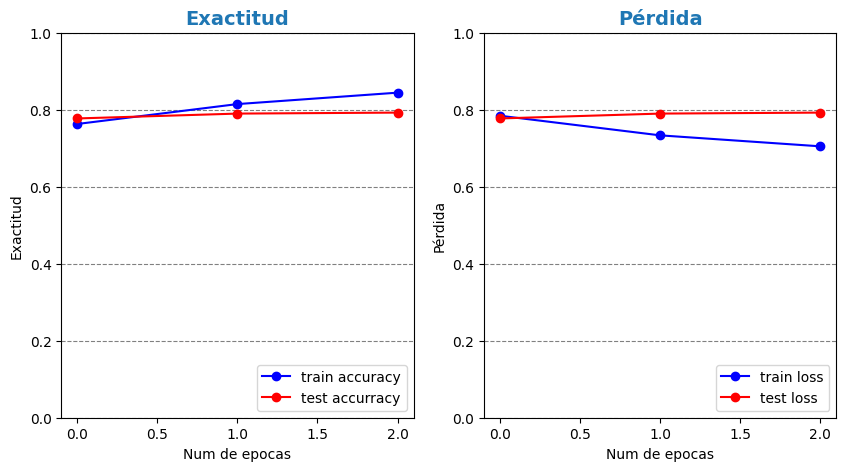

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10, 5))
colors = ['b','r','g','y','cyan']


ax[0].plot(lst_train_acc, 'b',label='train accuracy', marker = 'o')
ax[0].plot(lst_test_acc,'r',label = 'test accurracy', marker = 'o')

ax[0].set_xlabel("Num de epocas")
ax[0].set_ylabel("Exactitud")
ax[0].set_ylim([0, 1])
ax[0].set_title("Exactitud", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax[0].legend(loc = 'lower right')
ax[0].grid(axis = 'y', color = 'gray', linestyle = 'dashed')

ax[1].plot(lst_train_loss,'b',label = 'train loss', marker = 'o')
ax[1].plot(lst_test_loss,'r',label = 'test loss', marker = 'o')

ax[1].set_xlabel("Num de epocas")
ax[1].set_ylabel("Pérdida")
ax[1].set_ylim([0, 1])
ax[1].set_title("Pérdida", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax[1].legend(loc = 'lower right')
ax[1].grid(axis = 'y', color = 'gray', linestyle = 'dashed')

plt.show()

### Predicciónes del modelo

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = [] #texto sin procesar solo para mostrar la relación
    predictions = [] #predicciones
    prediction_probs = [] # probabilidades de predicción
    real_values = [] #valores reales o el sentimiento que corresponde

    with torch.no_grad():
        for d in data_loader:
            text = d['full_text']
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            #probs = F.softmax(outputs, dim=1)

            texts.extend(text)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)
    #Crear un DataFrame para revisar los resultados de las listas
    df_prediction = pd.DataFrame(list(zip(texts,predictions,prediction_probs,real_values)),
                                 columns = ['texts','predictions','prediction_probs','real_values'])

    #convertir las listas en tensores y retornar sus valores
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values, df_prediction

In [ ]:
y_texts, y_pred, y_pred_probs, y_test, df_prediction = get_predictions(
  model_sel,test_data_loader2)

In [ ]:
df_prediction

,texts,predictions,prediction_probs,real_values
0,"La @JEP_Colombia acaba de publicar el libro ""L...","tensor(1, device='cuda:0')","[tensor(6.2710e-05, device='cuda:0'), tensor(0...","tensor(1, device='cuda:0')"
1,🇨🇴Reafirmamos nuestra visión de poner al #empr...,"tensor(2, device='cuda:0')","[tensor(0.0002, device='cuda:0'), tensor(0.000...","tensor(2, device='cuda:0')"
2,"El relacionamiento entre empresas, academia y ...","tensor(1, device='cuda:0')","[tensor(0.0018, device='cuda:0'), tensor(0.639...","tensor(1, device='cuda:0')"
3,@WRadioColombia @DCoronell Yo creo q tiene más...,"tensor(0, device='cuda:0')","[tensor(0.9997, device='cuda:0'), tensor(0.000...","tensor(0, device='cuda:0')"
4,"Y a ti, ¿qué te hace sentir orgullosamente #ut...","tensor(2, device='cuda:0')","[tensor(0.0002, device='cuda:0'), tensor(0.000...","tensor(2, device='cuda:0')"
...,...,...,...,...
7046,"#TeContamos Breiner Fabián Saavedra Lomelin, e...","tensor(1, device='cuda:0')","[tensor(7.3088e-05, device='cuda:0'), tensor(0...","tensor(1, device='cuda:0')"
7047,📌Arrancamos las #CaravanasXLaJusticia en #Sant...,"tensor(1, device='cuda:0')","[tensor(9.5196e-05, device='cuda:0'), tensor(0...","tensor(1, device='cuda:0')"
7048,“Existen caminos menos violentos a través de l...,"tensor(1, device='cuda:0')","[tensor(0.0017, device='cuda:0'), tensor(0.515...","tensor(2, device='cuda:0')"
7049,María Isabel Urrutia: de primer oro olímpico a...,"tensor(1, device='cuda:0')","[tensor(0.0002, device='cuda:0'), tensor(0.999...","tensor(2, device='cuda:0')"


In [ ]:
class_names = ['Negativo', 'Neutro', 'Positivo']

**Informe de Clasificación**

In [ ]:
#informe de clasificación
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negativo       0.79      0.78      0.79      1442
      Neutro       0.78      0.82      0.80      3567
    Positivo       0.79      0.73      0.76      2042

    accuracy                           0.78      7051
   macro avg       0.79      0.78      0.78      7051
weighted avg       0.78      0.78      0.78      7051



**Evaluación de los datos de prueba**

In [ ]:
test_acc2, test_loss2 = eval_model(
        model_sel, test_data_loader2, loss_fn, device, n_examples=len(df_test2))
print('Prueba: Loss: {}, accuracy: {}'.format(test_loss2, test_acc2))

Prueba: Loss: 0.7628685438255379, accuracy: 0.7845695646007659


### Matriz de Confusión

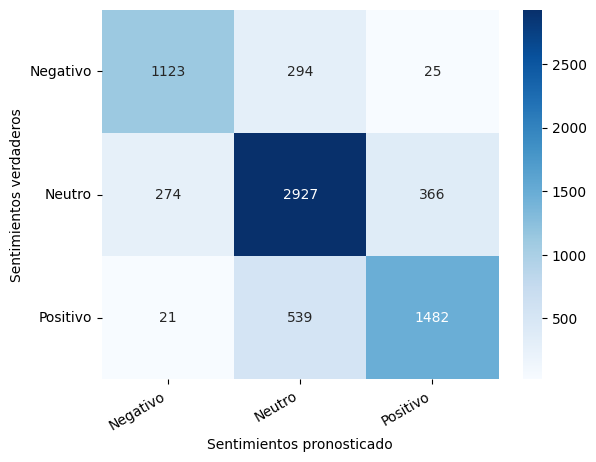

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Sentimientos verdaderos')
  plt.xlabel('Sentimientos pronosticado');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)